<a href="https://colab.research.google.com/github/sedahaus/colab-projects/blob/main/XGBoost_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from config import PREDICTION_HORIZON, MIN_PROFIT_THRESHOLD

def add_features(df, is_live=False):
    """
    is_live=True ise: Son günleri silmez (Tahmin yapmak için kullanırız).
    is_live=False ise: Son günleri siler (Eğitim için Target lazımdır).
    """
    df = df.copy()


    df['Log_Ret_1'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Log_Ret_5'] = np.log(df['Close'] / df['Close'].shift(5))


    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['Dist_SMA_10'] = (df['Close'] / df['SMA_10']) - 1

    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Dist_SMA_50'] = (df['Close'] / df['SMA_50']) - 1


    df['Volatility'] = df['Log_Ret_1'].rolling(window=10).std()


    if 'USD_Close' in df.columns:
        df['USD_Change'] = df['USD_Close'].pct_change()
    if 'BIST_Close' in df.columns:
        df['BIST_Change'] = df['BIST_Close'].pct_change()


    future_close = df['Close'].shift(-PREDICTION_HORIZON)
    df['Future_Return'] = (future_close / df['Close']) - 1
    df['Target'] = (df['Future_Return'] > MIN_PROFIT_THRESHOLD).astype(int)


    df.dropna(subset=['SMA_50', 'Volatility'], inplace=True)


    if not is_live:
        df.dropna(subset=['Target', 'Future_Return'], inplace=True)

    return df

ModuleNotFoundError: No module named 'config'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.shape

(7043, 21)

In [ ]:
df.drop('customerID', axis=1, inplace=True)

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Hedef değişkeni (Churn) 0 ve 1 yapalım
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   int64   
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   int64   
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

In [ ]:
# X ve y ayırımı
X = df.drop('Churn', axis=1)
y = df['Churn']

# Veriyi bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modeli oluşturma (enable_categorical=True çok önemli!)
model = xgb.XGBClassifier(
    tree_method="hist",
    enable_categorical=True,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)

# Sonuçları yazdır
print(f"Genel Doğruluk (Accuracy): {accuracy_score(y_test, y_pred):.2f}")
print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred))

Genel Doğruluk (Accuracy): 0.81

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



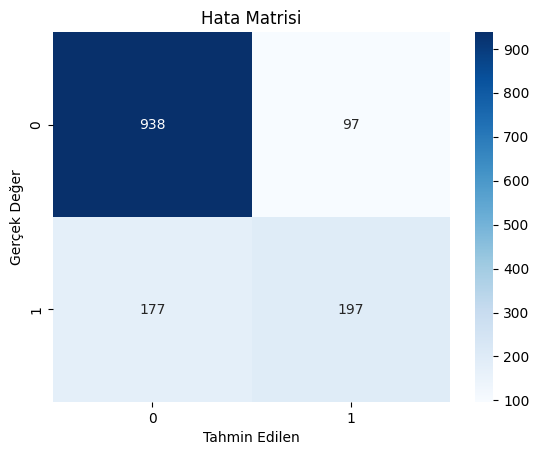

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('Hata Matrisi')
plt.show()

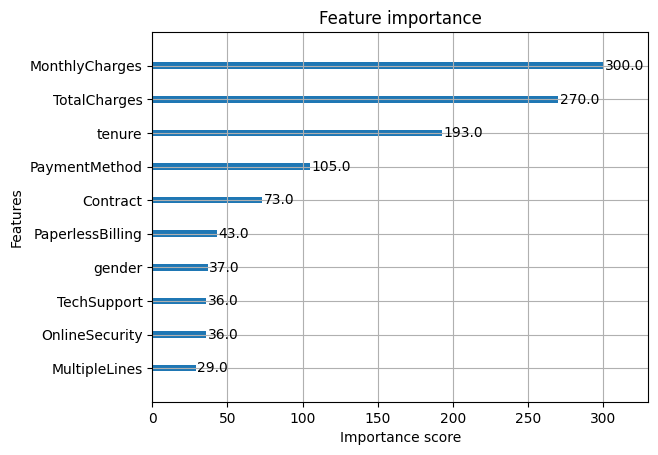

In [ ]:
# Hangi değişken model için daha önemli?
xgb.plot_importance(model, max_num_features=10) # En önemli 10 özelliği göster
plt.show()

In [ ]:
# Verimizdeki dengeyi hesaplayalım (Gitmeyenler / Gidenler)
# Genelde bu veri setinde oran yaklaşık 3'tür.
model_weighted = xgb.XGBClassifier(
    tree_method="hist",
    enable_categorical=True,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=3  # 1'lerin (Churn) ağırlığını artırdık
)

model_weighted.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = model_weighted.predict(X_test)

# Sonuçları yazdır
print(f"Genel Doğruluk (Accuracy): {accuracy_score(y_test, y_pred):.2f}")
print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred))

Genel Doğruluk (Accuracy): 0.75

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



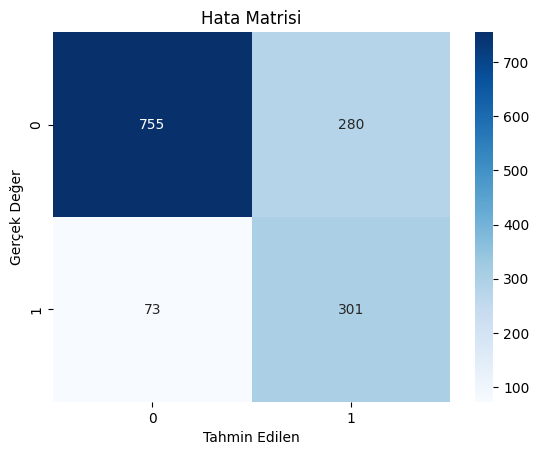

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('Hata Matrisi')
plt.show()

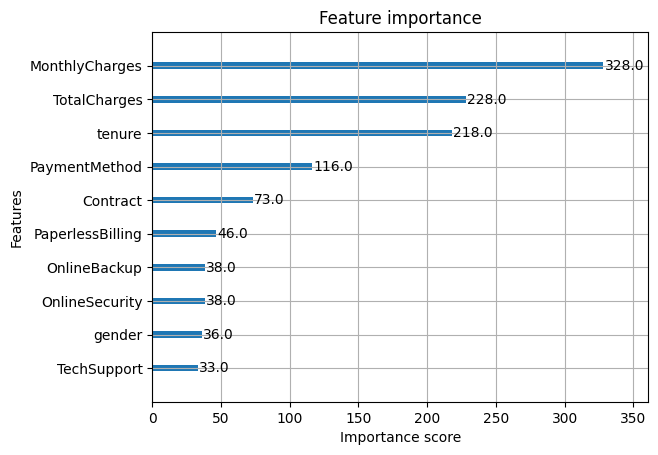

In [ ]:
xgb.plot_importance(model_weighted, max_num_features=10) # En önemli 10 özelliği göster
plt.show()

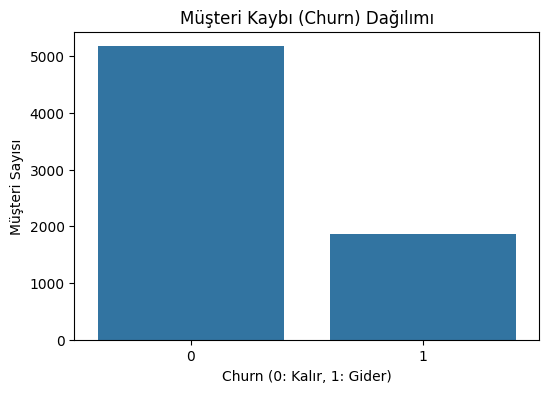

In [ ]:
#a) Churn Oranı Dağılımı
#Toplam müşteri içinde gidenlerin oranı nedir?
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Müşteri Kaybı (Churn) Dağılımı')
plt.xlabel('Churn (0: Kalır, 1: Gider)')
plt.ylabel('Müşteri Sayısı')
plt.show()

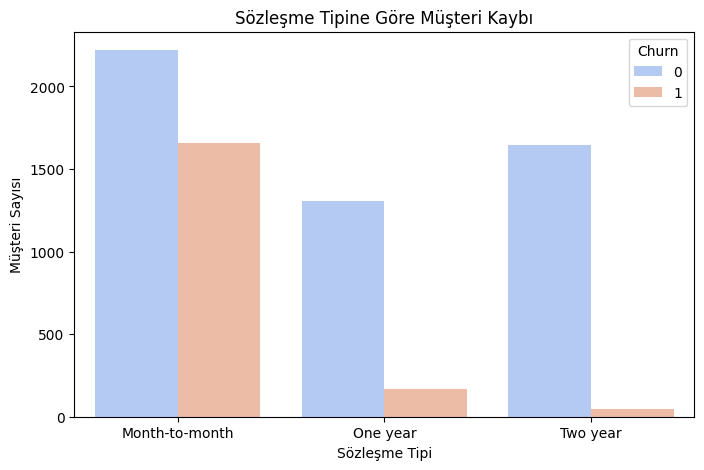

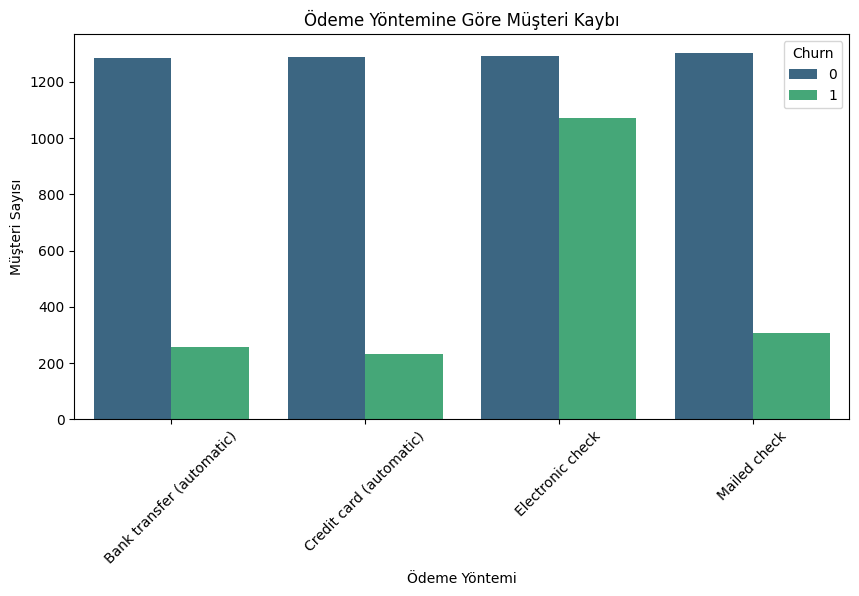

In [ ]:
#b) Önemli Kategorik Özelliklerin Churn ile İlişkisi
#odelin önemli bulduğu Contract ve PaymentMethod gibi kategorik değişkenlerin Churn ile ilişkisine bakalım.
# Örnek: Sözleşme tipine göre churn oranı
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df, palette='coolwarm')
plt.title('Sözleşme Tipine Göre Müşteri Kaybı')
plt.xlabel('Sözleşme Tipi')
plt.ylabel('Müşteri Sayısı')
plt.show()

# Örnek: Ödeme Yöntemine göre churn oranı
plt.figure(figsize=(10, 5))
sns.countplot(x='PaymentMethod', hue='Churn', data=df, palette='viridis')
plt.title('Ödeme Yöntemine Göre Müşteri Kaybı')
plt.xlabel('Ödeme Yöntemi')
plt.ylabel('Müşteri Sayısı')
plt.xticks(rotation=45) # Etiketler çakışmasın diye
plt.show()

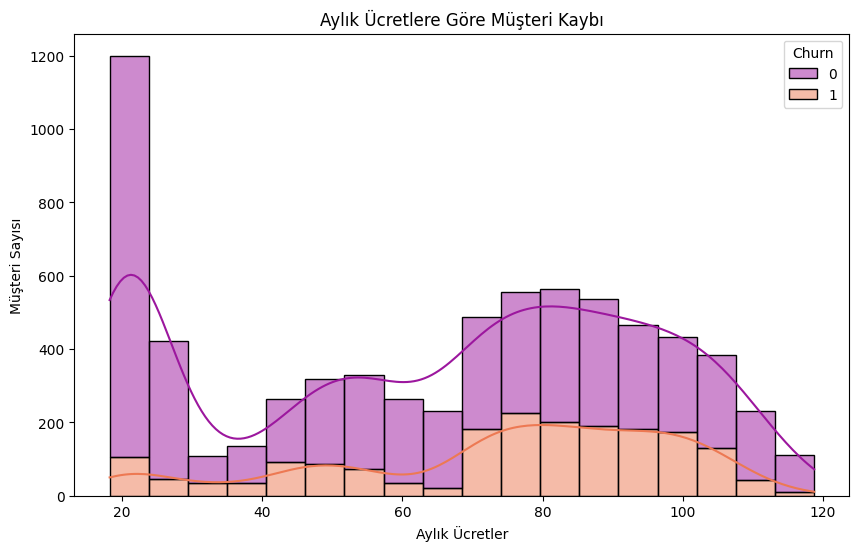

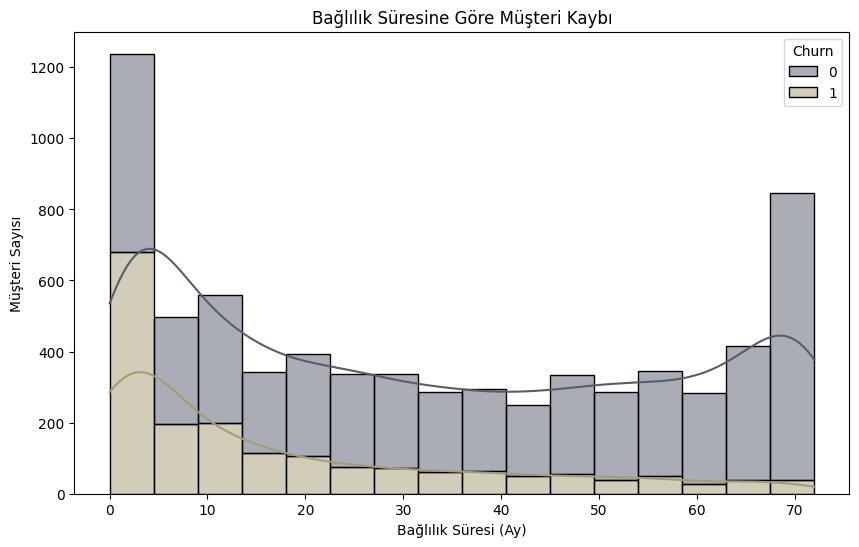

In [ ]:
#c) Önemli Sayısal Özelliklerin Churn ile İlişkisi
# Örnek: Aylık Ücretlere (MonthlyCharges) göre Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', kde=True, palette='plasma')
plt.title('Aylık Ücretlere Göre Müşteri Kaybı')
plt.xlabel('Aylık Ücretler')
plt.ylabel('Müşteri Sayısı')
plt.show()

# Örnek: Bağlılık Süresine (Tenure) göre Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True, palette='cividis')
plt.title('Bağlılık Süresine Göre Müşteri Kaybı')
plt.xlabel('Bağlılık Süresi (Ay)')
plt.ylabel('Müşteri Sayısı')
plt.show()

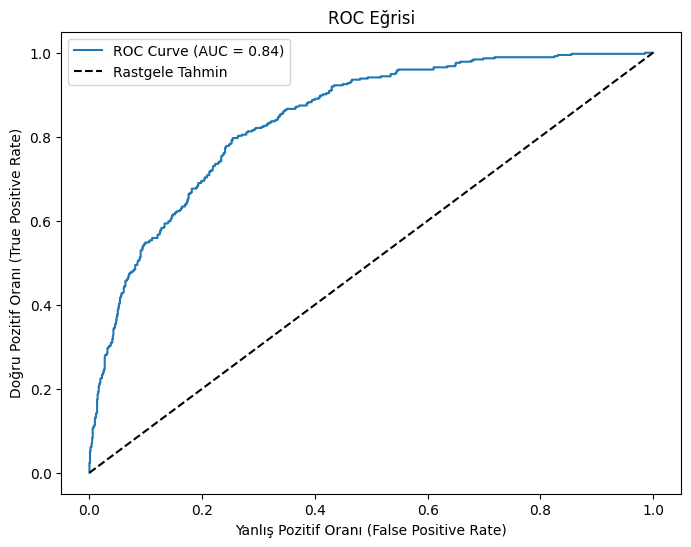

In [ ]:
#roc eğrisi
from sklearn.metrics import roc_curve, roc_auc_score

# Olasılıkları al (sınıf 1 için)
y_prob = final_model.predict_proba(X_test)[:, 1]

# ROC eğrisi verilerini hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Tahmin')
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
plt.title('ROC Eğrisi')
plt.legend()
plt.show()

In [ ]:
def churn_tahmin_et(musteri_verisi):
    # Veriyi modele uygun formata sokar
    tahmin_olasiligi = final_model.predict_proba(musteri_verisi)[:, 1]
    if tahmin_olasiligi > 0.5:
        return f"DİKKAT: Müşteri %{tahmin_olasiligi[0]*100:.2f} ihtimalle gidebilir!"
    else:
        return f"GÜVENLİ: Müşteri %{(1-tahmin_olasiligi[0])*100:.2f} ihtimalle kalıcı."

# Örnek kullanım: Test setindeki ilk müşteriyi kontrol edelim
print(churn_tahmin_et(X_test.iloc[[0]]))

GÜVENLİ: Müşteri %98.81 ihtimalle kalıcı.
